In [1]:
import pandas as pd
import numpy as np
import math
import scipy.optimize as optimize
import matplotlib.pyplot as plt

As in simple model, read in data as a pandas dataframe. This time, we also need Smax, Vmax and Tc. These are the maximum contribution of the 2nd order phase transition to S and V, and the critical temperature for the phase transition at P=0. 

In [2]:
filename="/home/nick/tc340/mac-version 4/tc-ds62.txt"

hpdata=[]
alldata=[]
names=[]
atoms=[]

with open(filename) as datafile:
    lines=datafile.readlines()
    for i in range(0, len(lines)-3):
        nameline=lines[i]
        stpline=lines[i+1]
        cpline=lines[i+2]
        akline=lines[i+3]
        if len(nameline) > 8 and nameline[7].isalpha():
            nameline=nameline.split()
            atoms=[]
            for j in range(3,len(nameline)):
                if j % 2:
                    atoms.append(float(nameline[j]))
            #nameline=nameline[0]
            #names.append(nameline)
            stpline=stpline.split()
            #stpline=stpline[0],stpline[1],stpline[2]
            #stp.append(stpline)
            cpline=cpline.split()
            #cp.append(cpline)
            akline=akline.split()
            if len(akline)==8:
                completeline=(sum(atoms),stpline[0],stpline[1],stpline[2],cpline[0],cpline[1],cpline[2],cpline[3],akline[0],akline[1],akline[2],akline[3],akline[4],akline[5],akline[6],akline[7])
            else:
                completeline=(sum(atoms),stpline[0],stpline[1],stpline[2],cpline[0],cpline[1],cpline[2],cpline[3],akline[0],akline[1],akline[2],akline[3],akline[4])   
            hpdata.append(completeline)
            names.append(nameline[0])
            #ak.append(akline)
            
index = pd.Index(names, name='rows')
columns = pd.Index(["atoms","H0","S0","V0","CpA","CpB","CpC","CpD","alpha0","k0","kprime0","kdprime0", "Landau", "Tc", "Smax", "Vmax"], name='cols')
hpdata = pd.DataFrame(hpdata, index=index, columns=columns)

Now we should have the Landau parameters in our Pandas dataframe:

In [3]:
print(hpdata.loc['q','Tc'],hpdata.loc['q','Smax'],hpdata.loc['q','Vmax'])

847 0.00495 0.1188


We can define the functions for the calculations as before:

In [4]:
def HtminusH(phase,T):
    return float(hpdata.loc[phase,'CpA'])*(T-298.15)+0.5*float(hpdata.loc[phase,'CpB'])*(T*T-298.15*298.15)-float(hpdata.loc[phase,'CpC'])*(1/T-1/298.15)+2*float(hpdata.loc[phase,'CpD'])*(math.sqrt(T)-math.sqrt(298.15))

def StminusS(phase,T):
    return 1000*(float(hpdata.loc[phase,'CpA'])*math.log(T/298.15)+float(hpdata.loc[phase,'CpB'])*(T-298.15)-0.5*float(hpdata.loc[phase,'CpC'])*(1/(T*T)-1/(298.15*298.15))-2*float(hpdata.loc[phase,'CpD'])*(1/math.sqrt(T)-1/math.sqrt(298.15)))

def GTP0(phase,T):
    return ((float(hpdata.loc[phase,'H0'])+HtminusH(phase,T))*1000)-(((float(hpdata.loc[phase,'S0']))*1000)+StminusS(phase,T))*T

def EOSa(phase,P):
     return (1+float(hpdata.loc[phase, 'kprime0']))/((1+float(hpdata.loc[phase, 'kprime0'])+(float(hpdata.loc[phase, 'k0'])*float(hpdata.loc[phase, 'kdprime0']))))

def EOSb(phase,P):
     return (float(hpdata.loc[phase, 'kprime0'])/float(hpdata.loc[phase, 'k0']))-float(hpdata.loc[phase, 'kdprime0'])/(1+float(hpdata.loc[phase, 'kprime0']))

def EOSc(phase,P):
     return (1+float(hpdata.loc[phase, 'kprime0'])+float(hpdata.loc[phase, 'k0'])*float(hpdata.loc[phase, 'kdprime0']))/(float(hpdata.loc[phase, 'kprime0'])*float(hpdata.loc[phase, 'kprime0'])+float(hpdata.loc[phase, 'kprime0'])-float(hpdata.loc[phase, 'k0'])*float(hpdata.loc[phase, 'kdprime0']))

def Pth(phase,T):
    theta=10636/(((float(hpdata.loc[phase, 'S0'])*1000)/float(hpdata.loc[phase, 'atoms']))+6.44)
    xi0=(theta/298.15)*(theta/298.15)*math.exp(theta/298.15)/((math.exp(theta/298.15)-1)*(math.exp(theta/298.15)-1))
    Pthermal=float(hpdata.loc[phase, 'alpha0'])*float(hpdata.loc[phase, 'k0'])*theta/xi0*(1/(math.exp(theta/T)-1)-1/(math.exp(theta/298.15)-1))
    return(Pthermal)

def V(phase,P,T):
    return float(hpdata.loc[phase, 'V0'])*(1-EOSa(phase,P)*(1-math.pow((1+EOSb(phase,P)*(P-Pth(phase,T))),(-EOSc(phase,P)))))

def PVcorr(phase,P,T):
    return 1-EOSa(phase,P)+(EOSa(phase,P)*(math.pow((1-EOSb(phase,P)*Pth(phase,T)),(1-EOSc(phase,P)))-math.pow((1+EOSb(phase,P)*(P-Pth(phase,T))),(1-EOSc(phase,P))))/(EOSb(phase,P)*(EOSc(phase,P)-1)*P))

def GPTminusGP0T(phase,P,T):
    return PVcorr(phase,P,T)*P*float(hpdata.loc[phase, 'V0'])

# We will redefine this function to check for Landau

#def GPT(phase,P,T):
#    return GTP0(phase,T)+GPTminusGP0T(phase,P,T)*1000

But we need to have some kind of logic test to check whether we need to use the Landau model for a second order phase transition. We can put this into the function to return G at P,T

In [5]:
def GPT(phase,P,T):
    if hpdata.loc[phase,'Landau']=="0":
        return GTP0(phase,T)+GPTminusGP0T(phase,P,T)*1000
    else:
        return GTP0(phase,T)+GPTminusGP0T(phase,P,T)*1000+Glandau(phase,P,T)

Now we need to define a function called Glandau to calculate the Landau contribution to G(P,T) (returned in Joules): 

In [6]:
def Glandau(phase,P,T):
    # retrieve relevant data from dataframe
    Tc=float(hpdata.loc[phase,'Tc'])
    Vmax=float(hpdata.loc[phase,'Vmax'])
    Smax=float(hpdata.loc[phase,'Smax'])
    # define T*c in terms of Vmax, Smax and P
    Tsc=Tc+(Vmax/Smax)*P
    # if T above critical T, Q=0
    if T<Tsc:
        Q=math.pow(((Tsc-T)/Tc),0.25)
    else:
        Q=0
    Q298=math.pow(((Tc-298.15)/Tc),0.25)
    return (Tc*Smax*(Q298**2-(1/3)*Q298**6)-Smax*(Tsc*Q**2-(1/3)*Tc*Q**6)-T*(Smax*(Q298**2-Q**2))+P*(Vmax*Q298**2))*1000

In [7]:
print(Glandau('q',10,1273.15))

-1470.73481548565


In [8]:
print(GPT('q',20,1273.15))

-968916.188441936


Take univariant seek function from before:

In [9]:
def univariantPseek(Pguess,T,phase1,phase2):
    def univariantPcalc(P,T,phase1,phase2):
        return GPT(phase1,P,T)-GPT(phase2,P,T)
    return optimize.newton(univariantPcalc, x0=Pguess, args=(T, phase1, phase2))

In [10]:
print('Ptr q=coe at 1273.15 K:', univariantPseek(40,1273.15,'q','coe'),'kbar')

Ptr q=coe at 1273.15 K: 30.614123550859667 kbar


This is within the bracket (30.6-30.9 kbar) from Bose & Ganguly (1995). We can use a for loop to find model values for the pressure of the quartz=coesite transition at intervals of 10 °C over the temperature range investigated experimentally by Bose & Ganguly, and compare this to their linear fit of the boundary (P(kbar)=21.945+0.006901*T(K)).

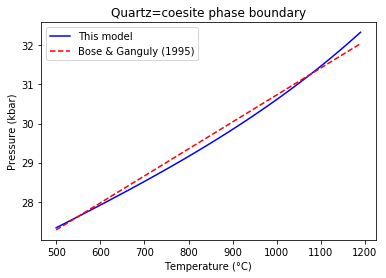

In [11]:
Trange=np.arange(500,1200,10)
TrangeK=Trange+273.15

modelPcurve=[]
bgPcurve=[]

for i in range(0,len(TrangeK)):
    modelPcurve.append(univariantPseek(30,TrangeK[i],'q','coe'))
    bgPcurve.append(21.945+0.006901*TrangeK[i])
    
plt.plot(Trange,modelPcurve,'b-',label="This model")
plt.plot(Trange,bgPcurve,'r--', label="Bose & Ganguly (1995)")
plt.xlabel('Temperature (°C)')
plt.ylabel('Pressure (kbar)')
plt.title('Quartz=coesite phase boundary')
plt.legend()
plt.show()